In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from scipy.stats import ttest_ind, mannwhitneyu
from matplotlib import cm
from scipy.ndimage import gaussian_filter


# This is custom Made .py files, we import them as tere are functions we need to unpack and prepare the data
from Parser import parse_samples, parse_events, convert_dict_to_df
from Renderer import drawing_traces
from video_traces import movie_traces

In [2]:
''' Data variables
* asc_samples_pd : only timesteps when recording
    notes: there are gaps in data - it is when eye tracker were paused (no recordings)
    pd.DataFrame:
        columns: time, x, y, pupil 
'''

'''
asc_samples_pd: 
    columns: time, x, y, pupil
trials_data:
    columns: path_name_trial, start_trial, end_trial, num_fix, num_sacc, num_blinks 
'''

'\nasc_samples_pd: \n    columns: time, x, y, pupil\ntrials_data:\n    columns: path_name_trial, start_trial, end_trial, num_fix, num_sacc, num_blinks \n'

In [3]:
# 0. Defining file paths

current_path = os.getcwd()

respondents = ['resp_0'] #TODO here we will read a txt file that contain ALL info about all resp folder names
# in that case only 'resp_0'
current_respondent = respondents[0] #TODO loop or whatever

respondent_folder = os.path.join(current_path, current_respondent)
data_folder_name = current_respondent + '/Data'
stimuli_folder_name = current_respondent + '/Stimuli'

samples_only_folder = 'asc_samples_only'
events_only_folder = 'asc_events_only'
events_samples_folder = 'asc_events_samples'
data_path = os.path.join(current_path, data_folder_name)

# important paths
data_samples_path = os.path.join(data_path, samples_only_folder)
data_events_path = os.path.join(data_path, events_only_folder)
data_events_samples_path = os.path.join(data_path, events_samples_folder)
stimuli_path = os.path.join(current_path, stimuli_folder_name)


filenames = [f for f in os.listdir(os.path.join(data_path, 'edf')) if f.endswith('.edf')]

In [4]:
# STATE HERE ........training
# Here are the names of teh file
# file_name = 'alyatrainingtrack.asc' #TODO: loop or whatever
# experiment_name = 'alyatrainingtrack'
# stimuli_name = 'training/images'
# STATE HERE ........

experiments = ['A', 'B', 'C', 'D']
durations = {}
fixations = {}
trials_data_dict = {}
asc_samples_dict  = {}
csv_dict = {}
fixations_pd_in_dict = {}
stimuli_img_path_dict =  {}
write_traces_folder_dict = {}
write_video_folder_dict ={}
saccades_dict ={}


In [5]:
for i, exp in enumerate(experiments):
    if exp == 'A':
        # STATE HERE ........12_A
        file_name = 'alya12_atrack.asc' #TODO: loop or whatever
        experiment_name = 'alya12_atrack'
        stimuli_name = 'stimuli_exp_12_a'
        # STATE HERE ........
    elif exp == 'B':
        # STATE HERE ........12_B
        file_name = 'alya12_btrack.asc' #TODO: loop or whatever
        experiment_name = 'alya12_btrack'
        stimuli_name = 'stimuli_exp_12_b'
        # STATE HERE ........
    elif exp == 'C':
        # STATE HERE ........12_C
        file_name = 'alya12_ctrack.asc' #TODO: loop or whatever
        experiment_name = 'alya12_ctrack'
        stimuli_name = 'stimuli_exp_12_c'
        # STATE HERE ........
    elif exp == 'D':
        # STATE HERE ........12_D
        file_name = 'alya12_dtrack.asc' #TODO: loop or whatever
        experiment_name = 'alya12_dtrack'
        stimuli_name = 'stimuli_exp_12_d'
        # STATE HERE ........


    print('EXPERIMENT:')
    print(experiment_name)
    print('--------------------------')

    # STimuli for experiment
    stimuli_img_path = os.path.join(stimuli_path, stimuli_name, 'images')
    stimuli_img_path_dict[exp] = stimuli_img_path

    # Traces images paths 
    traces_folder = os.path.join(data_path, 'traces')
    os.makedirs(traces_folder) if not os.path.exists(traces_folder) else None
    write_traces_folder = os.path.join(traces_folder, experiment_name)
    os.makedirs(write_traces_folder) if not os.path.exists(write_traces_folder) else None

    write_traces_folder_dict[exp] = write_traces_folder
    # saccades_dict[exp] = sacc_data # IMOSE added


    # Video gaze path
    video_path = os.path.join(data_path, 'video')
    os.makedirs(video_path) if not os.path.exists(video_path) else None
    write_video_folder = os.path.join(video_path, experiment_name)
    os.makedirs(write_video_folder) if not os.path.exists(write_video_folder) else None

    write_video_folder_dict[exp] = write_video_folder

    # 1. Parsing samples
    event_samples = os.path.join(data_events_samples_path, file_name)
    events_path = os.path.join(data_events_path, file_name)
    samples_path = os.path.join(data_samples_path, file_name)
    asc_samples_pd = parse_samples(samples_path)


    # 2. Parsing events
    meta, events = parse_events(events_path)
    trials_data, fix_data, sacc_data, blink_data = convert_dict_to_df(events)
    trials_data['duration_sec'] = (trials_data['end_trial'] - trials_data['start_trial']) / 1000
    saccades_dict[exp] = sacc_data #Alina: [in my, when this line at previous position it gives error, so I put it here]

    # 3. Reading info about trials
    csv_folder_name = stimuli_name + '/csv'
    file_name = 'experiment.csv'
    csv_path = os.path.join(stimuli_path, csv_folder_name, file_name)
    csv_iminfo = pd.read_csv(csv_path, sep=';', encoding='utf-8')
    last_trial_number = csv_iminfo['N_trial'].max() + 1
    new_name = f'c:\\Users\\Alina\\Downloads\\Mental_Rotation_and_Lab\\pop_out_effect_code\\experiment_results\\exp_0\\images\\image_{int(last_trial_number)}.png'
    # 3. Define the condition
    condition = (
        (csv_iminfo['N_trial'] == 0) &
        (csv_iminfo['name'] == r'c:\Users\Alina\Downloads\Mental_Rotation_and_Lab\pop_out_effect_code\experiment_results\exp_0\images\image_0.png')
    )
    csv_iminfo.loc[condition, 'N_trial'] = last_trial_number
    csv_iminfo.loc[condition, 'name'] = new_name

    # Data analysis

    trials_data['trial_id'] = trials_data['trial_id'].astype(int)

    trial_data_merged = pd.merge(trials_data, csv_iminfo[['N_trial', 'target_presence']],
                        left_on='trial_id', right_on='N_trial',
                        how='left')  # or 'inner' if you're sure all match
    trial_data_merged.drop(columns='N_trial', inplace=True)


    fix_data['trial_id_num'] = fix_data['trial_id'].astype(int)
    fixation_data_merged = pd.merge(fix_data, csv_iminfo[['N_trial', 'target_presence']],
                        left_on='trial_id_num', right_on='N_trial',
                        how='left')  # or 'inner' if you're sure all match
    fixation_data_merged.drop(columns='N_trial', inplace=True)

    # 1. All data description
    data_desc = trial_data_merged[['duration_sec', 'num_sacc', 'num_blinks', 'num_fix']].describe()
    # print('ALL_DATA:', '\n')
    # print(data_desc, '\n')

    # 2. Target only description
    trials_data_target = trial_data_merged[trial_data_merged['target_presence']==True]
    target_desc = trials_data_target[['duration_sec', 'num_sacc', 'num_blinks', 'num_fix']].describe()
    # print('TARGET_ONLY:', '\n')
    # print(target_desc, '\n') 

    # 3. NO Target description
    trials_data_NO_target = trial_data_merged[trial_data_merged['target_presence']==False]
    NO_target_desc = trials_data_NO_target[['duration_sec', 'num_sacc', 'num_blinks', 'num_fix']].describe()
    # print('NO_TARGET:', '\n')
    # print(NO_target_desc, '\n')


    # Preparing data for all experiments together 
    durations[exp] = np.array(trials_data_target['duration_sec'])
    fixations[exp] = {}
    trials_data_dict[exp] = trial_data_merged
    asc_samples_dict[exp] = asc_samples_pd
    csv_dict[exp] = csv_iminfo
    fixations_pd_in_dict[exp] = fixation_data_merged

    # Group by trial_id
    for trial_id, group in fix_data.groupby('trial_id'):
        fixations[exp][str(trial_id)] = {
            'x': group['avrxpos'].to_numpy(),
            'y': group['avrypos'].to_numpy(),
            'duration': group['duration'].to_numpy()
        }

EXPERIMENT:
alya12_atrack
--------------------------
EXPERIMENT:
alya12_btrack
--------------------------
EXPERIMENT:
alya12_ctrack
--------------------------
EXPERIMENT:
alya12_dtrack
--------------------------


# Calibration 

In [26]:
width = 1920
height = 1080

for experiment in experiments:
    # Set up an empty heatmap
    heatmap = np.zeros((height, width)) # height - rows, width - columns
    # Loop over trials 1 to 60
    for trial_num in range(1, 61):
        trial = str(trial_num)  # make sure keys are strings
        if trial in fixations[experiment]:  # check if trial exists
            x = fixations[experiment][trial]['x']
            y = fixations[experiment][trial]['y']
            fix_duration = fixations[experiment][trial]['duration']

            for xi, yi, di in zip(x, y, fix_duration):
                if 0 <= xi < width and 0 <= yi < height:
                    heatmap[int(yi), int(xi)] += di

    # Save original max for rescaling
    original_max = heatmap.max()

    # Apply Gaussian smoothing
    heatmap_smooth = gaussian_filter(heatmap, sigma=25)

    # Rescale to preserve original max
    heatmap_smooth *= original_max / heatmap_smooth.max()

    # Download coordinates 
    with open('grid_coords.txt', 'r') as f:
        grid_coords_txt = [tuple(map(int, line.strip().split(','))) for line in f]

    x_grid_coord, y_grid_coord = zip(*grid_coords_txt)


    max_y, max_x = np.unravel_index(np.argmax(heatmap_smooth), heatmap_smooth.shape)
    if experiment != 'C':
        center_x, center_y = x_grid_coord[12], y_grid_coord[12] #center of the grid 
    else:
        center_x, center_y = x_grid_coord[16], y_grid_coord[16] #center of the grid 
    # Plot
    # plt.figure(figsize=(12, 7))
    # img = plt.imshow(heatmap_smooth, cmap='hot', interpolation='bilinear')
    # plt.scatter(x_grid_coord, y_grid_coord, c='white', marker='x', s=50, linewidths=1)
    # plt.colorbar(img, label='Fixation Duration (ms)')
    # plt.title("Summed Gaze Duration Heatmap: "+ experiment)
    # #plt.colorbar(img, label='Fixation Duration (ms)')
    # plt.axis('off')
    # # plt.show()


    # SHIFTED SCATTER
    dy = center_y - max_y
    dx = center_x - max_x

    fixations_pd_in_dict[experiment]['shifted_avrxpos'] = fixations_pd_in_dict[experiment]['avrxpos'] + dx
    fixations_pd_in_dict[experiment]['shifted_avrypos'] = fixations_pd_in_dict[experiment]['avrypos'] + dy
    
    # Shift the smoothed heatmap
    from scipy.ndimage import shift
    heatmap_shifted = shift(heatmap_smooth, shift=(dy, dx), mode='constant', cval=0)

    plt.figure(figsize=(12, 7))
    # img = plt.imshow(heatmap_shifted, cmap='hot', interpolation='bilinear')
    # plt.scatter(x_grid_coord, y_grid_coord, c='white', marker='x', s=50, linewidths=1)
    # plt.colorbar(img, label='Fixation Duration (ms)')
    # plt.title("Shifted Summed Gaze Duration Heatmap: "+ experiment)
    # #plt.colorbar(img, label='Fixation Duration (ms)')
    # plt.axis('off')
    # # plt.show()


    # DRAWING shifted traces
    for i in range(1, 61):
        trial_id = str(i)
        # trials_data_dict[experiment] = trials_trials_data_dict[experiment]_dict[experiment]
        trial_info = trials_data_dict[experiment].loc[trials_data_dict[experiment]['trial_id'] == int(trial_id)]

        stime = trial_info['start_trial'].iloc[0]
        etime = trial_info['end_trial'].iloc[0]
        asc = asc_samples_dict[experiment]
        timestemps = asc.loc[(asc['time'] >= stime) & (asc['time'] <= etime)].copy().assign(x=lambda df: df['x'] + dx,
                          y=lambda df: df['y'] + dy)

        
        csv_data = csv_dict[experiment]
        target_area = csv_data.loc[csv_data['N_trial'] == int(trial_id)]
        
        fix = fixations_pd_in_dict[experiment].loc[fixations_pd_in_dict[experiment]['trial_id'] == str(trial_id)].copy().assign(
            avrxpos=lambda df: df['avrxpos'] + dx, 
            avrypos=lambda df: df['avrypos'] + dy
)
        


        traces = drawing_traces(stimuli_img_path_dict[experiment], write_traces_folder_dict[experiment], stimuli_path, 
                                trial_id, timestemps, 
                                fix, target_area)
        
        
        #  *UNCOMMENT* Video traces movie
        # img_path = os.path.join(write_traces_folder_dict[experiment], f'traces_trial_{i}.png')
        # movie_traces(img_path, timestemps, i, write_video_folder_dict[experiment])

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

# Average Saccades distance: target_presence = True

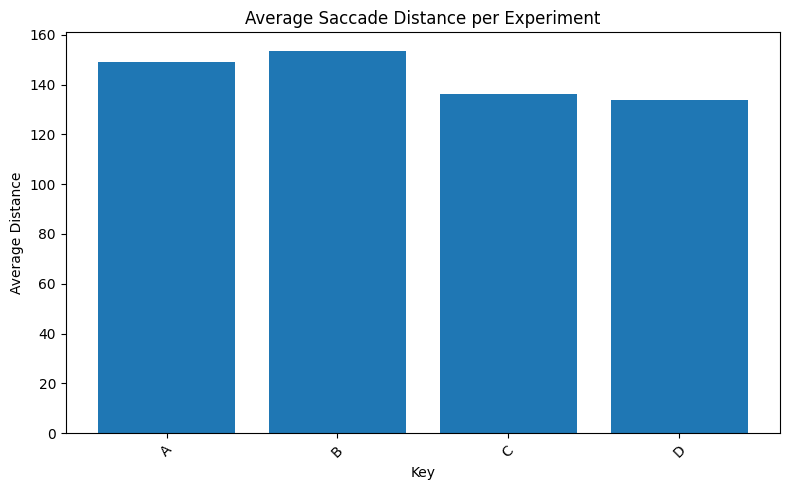

In [7]:

trials_data_dict['A'] #trial_id - we have column target_presence, only select those, when target is present target_presence==True
saccades_dict['A'] #trial_id
# select only those rows that saccades_dict['A'] 

# 1. Get the trials where target is present
present_trials = trials_data_dict['A'].loc[
    trials_data_dict['A']['target_presence'] == True, 'trial_id'
]

# 2. Filter saccades from those trials
saccades_with_target = saccades_dict['A'].loc[
    saccades_dict['A']['trial_id'].isin(present_trials)
]

for k in sorted(experiments):
    trials = trials_data_dict[k]
    sacc   = saccades_dict[k]

    for col in ['sxpos', 'sypos', 'expos', 'eypos']:
        sacc[col] = pd.to_numeric(sacc[col], errors='coerce')

    sacc['distance'] = np.sqrt((sacc['expos'] - sacc['sxpos'])**2 +
                               (sacc['eypos'] - sacc['sypos'])**2)
    

avg_distances = {}

for key, df in saccades_dict.items():
    avg_distances[key] = df['distance'].mean()

avg_df = pd.DataFrame(list(avg_distances.items()), columns=['Key', 'AverageDistance'])


plt.figure(figsize=(8, 5))
plt.bar(avg_df['Key'], avg_df['AverageDistance'])
plt.title('Average Saccade Distance per Experiment')
plt.xlabel('Key')
plt.ylabel('Average Distance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()






## T-test: significance of saccadic distances

In [8]:
from scipy.stats import ttest_ind

a = saccades_dict['A']['distance'].dropna()
b = saccades_dict['B']['distance'].dropna()
c = saccades_dict['C']['distance'].dropna()
d = saccades_dict['D']['distance'].dropna()

# two-tailed, independent t-tests
t_ab, p_ab = ttest_ind(a, b, equal_var=False)
t_bc, p_bc = ttest_ind(b, c, equal_var=False)
t_cd, p_cd = ttest_ind(c, d, equal_var=False)

print("T-test results, unequal variance):")
print(f"A vs B: t = {t_ab:.3f}, p = {p_ab:.6f}")
print(f"B vs C: t = {t_bc:.3f}, p = {p_bc:.6f}")
print(f"C vs D: t = {t_cd:.3f}, p = {p_cd:.6f}")

ttest_results = pd.DataFrame({
    'Comparison': ['A vs B', 'B vs C', 'C vs D'],
    't_value': [t_ab, t_bc, t_cd],
    'p_value': [p_ab, p_bc, p_cd]
})
print(ttest_results)

T-test results, unequal variance):
A vs B: t = -0.656, p = 0.512241
B vs C: t = 4.646, p = 0.000004
C vs D: t = 0.989, p = 0.322758
  Comparison   t_value   p_value
0     A vs B -0.655812  0.512241
1     B vs C  4.646403  0.000004
2     C vs D  0.988920  0.322758


In [9]:
#OLD PLOT

for key, df in saccades_dict.items():
    for col in ['sxpos', 'sypos', 'expos', 'eypos']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df['distance'] = np.sqrt((df['expos'] - df['sxpos'])**2 + (df['eypos'] - df['sypos'])**2)

for key, df in saccades_dict.items():
    df['distance'] = np.sqrt((df['expos'] - df['sxpos'])**2 + (df['eypos'] - df['sypos'])**2)


#print(saccades_dict['A'])

#PLOT

avg_distances = {}

for key, df in saccades_dict.items():
    avg_distances[key] = df['distance'].mean()

avg_df = pd.DataFrame(list(avg_distances.items()), columns=['Key', 'AverageDistance'])

#plt.figure(figsize=(8, 5))
#plt.bar(avg_df['Key'], avg_df['AverageDistance'])
#plt.title('Average Distance per Key')
#plt.xlabel('Key')
#plt.ylabel('Average Distance')
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.show()

In [10]:
present_trials = []

for key, df in trials_data_dict.items():
    trials = df.loc[df['target_presence'] == True].copy()
    trials['experiment'] = key
    present_trials.append(trials)

present_trials = pd.concat(present_trials, ignore_index=True)
#present_trials.head(60)     

target_coords = []

# Alina: the for-loop that below I think can be removed (if I understoos correctly, cause the next loop does same)

for key, df in csv_dict.items():
    coords = df.loc[df['N_trial'].isin(present_trials['trial_id']), ['N_trial', 'target_coordinates']].copy()
    coords['experiment'] = key
    target_coords.append(coords)

target_coords = {}

for key, df in csv_dict.items():
    coords = df.loc[
        df['N_trial'].isin(present_trials['trial_id']),
        ['N_trial', 'target_coordinates']
    ].copy()
    coords['experiment'] = key
    target_coords[key] = coords

for key, df in target_coords.items():
    xy = df['target_coordinates'].str.extract(r'\(?\s*(\d+)\s*,\s*(\d+)\s*\)?').astype(float)
    xy.columns = ['txpos', 'typos']
    df[['txpos', 'typos']] = xy
    df.drop(columns='target_coordinates', inplace=True)
    target_coords[key] = df


first_fixations_in_trial = {}     #First THREE fixations

for key, df in fixations_pd_in_dict.items():
    subset = df.loc[df['target_presence'] == True, ['trial_id', 'avrxpos', 'avrypos']].copy()
    subset['trial_id'] = pd.to_numeric(subset['trial_id'], errors='coerce').astype('Int64')

    subset['rank'] = subset.groupby('trial_id').cumcount() + 1
    first3 = subset[subset['rank'] <= 3]

    wide = (first3
            .set_index(['trial_id', 'rank'])[['avrxpos', 'avrypos']]
            .unstack('rank'))
    wide.columns = [f'{c}_{r}' for c, r in wide.columns]
    wide = wide.reset_index()

    first_fixations_in_trial[key] = wide



#COMBINING target_coords AND first_fixations_in_trial INTO ONE 


final_dict = {}

for key in target_coords.keys():
    df_target = target_coords[key].copy()
    df_fix = first_fixations_in_trial.get(key)
    
    merged = pd.merge(
        df_target,
        df_fix,
        left_on='N_trial',  
        right_on='trial_id',
        how='inner'
    )

    merged.drop(columns='trial_id', inplace=True, errors='ignore')
    
    final_dict[key] = merged



print(final_dict['B'])






                 

    N_trial experiment   txpos  typos  avrxpos_1  avrxpos_2  avrxpos_3  \
0         2          B   690.0  270.0     1086.1     1040.3     1063.5   
1         3          B   695.0  531.0     1042.4     1058.2      949.6   
2         6          B   970.0  254.0     1044.8     1074.0      920.1   
3         7          B   824.0  535.0     1026.3     1071.3     1007.9   
4         8          B   695.0  820.0      985.8      898.5      921.9   
5         9          B   678.0  814.0     1062.6     1051.4      939.3   
6        10          B   963.0  409.0     1030.1     1019.4      886.1   
7        11          B  1231.0  675.0     1094.1      982.9     1048.9   
8        12          B   699.0  265.0     1043.6     1006.9     1077.3   
9        13          B   815.0  527.0     1074.2     1043.1      951.5   
10       14          B  1109.0  541.0     1060.1      950.8     1247.8   
11       15          B  1229.0  807.0     1025.6     1124.5     1056.6   
12       16          B  1095.0  809.0 

# NEW CORRECTED CODE AND PLOT

In [11]:
def get_quarter(x, y):
  
    if x <= 960 and y <= 540:
        return "I"
    elif x > 960 and y <= 540:
        return "II"
    elif x <= 960 and y > 540:
        return "III"
    else:
        return "IIII"

def plot_trial_quarters(final_dict, exp_key, trial_id, trial_col='N_trial',
                        x_target_col='txpos', y_target_col='typos',
                        fix_x_cols=('avrxpos_1', 'avrxpos_2', 'avrxpos_3'),
                        fix_y_cols=('avrypos_1', 'avrypos_2', 'avrypos_3')):


    df = final_dict[exp_key]
    row = df.loc[df[trial_col] == trial_id]
    if row.empty:
        raise ValueError(f"trial_id {trial_id} not found in experiment {exp_key}")

    r = row.iloc[0]

    tx, ty = float(r[x_target_col]), float(r[y_target_col])
    target_quarter = get_quarter(tx, ty)

    print(f"\nExperiment {exp_key}, trial_id {trial_id}")
    print(f"Target: ({tx:.1f}, {ty:.1f}) → quarter {target_quarter}")

    same_quarter_found = False
    for i, (fx_col, fy_col) in enumerate(zip(fix_x_cols, fix_y_cols), start=1):
        fx, fy = float(r[fx_col]), float(r[fy_col])
        f_quarter = get_quarter(fx, fy)
        print(f"Fixation {i}: ({fx:.1f}, {fy:.1f}) → quarter {f_quarter}")

        if f_quarter == target_quarter:
            same_quarter_found = True

    print(f"At least one fixation in same quarter? {'YES' if same_quarter_found else 'NO'}")


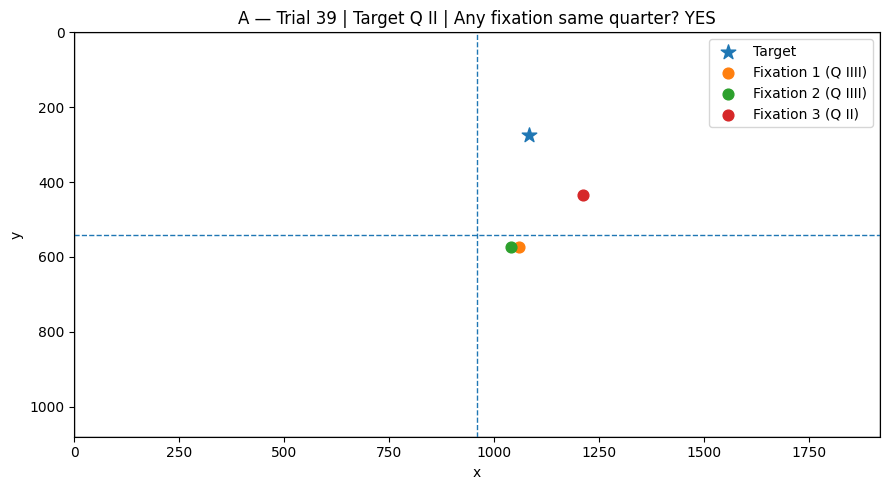

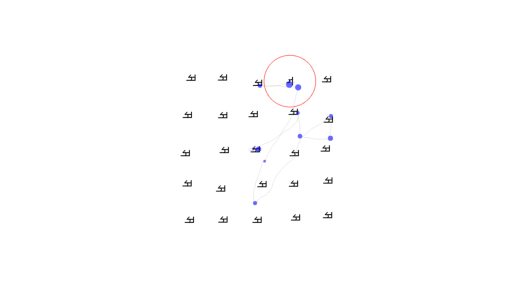

In [12]:
import matplotlib.pyplot as plt

def plot_single_trial_screen(final_dict, exp_key, trial_id, trial_col='N_trial',
                             x_target_col='txpos', y_target_col='typos',
                             fix_x_cols=('avrxpos_1','avrxpos_2','avrxpos_3'),
                             fix_y_cols=('avrypos_1','avrypos_2','avrypos_3')):
    df = final_dict[exp_key]
    row = df.loc[df[trial_col] == trial_id]
    if row.empty:
        raise ValueError(f"trial_id {trial_id} not found in experiment {exp_key}")
    r = row.iloc[0]

    tx, ty = float(r[x_target_col]), float(r[y_target_col])
    tq = get_quarter(tx, ty)

    fixes = []
    for fx_col, fy_col in zip(fix_x_cols, fix_y_cols):
        fx, fy = float(r[fx_col]), float(r[fy_col])
        fixes.append((fx, fy, get_quarter(fx, fy)))

    match_any = any(fq == tq for (_,_,fq) in fixes) #

    W, H = 1920, 1080
    fig, ax = plt.subplots(figsize=(9, 5))

    ax.add_patch(plt.Rectangle((0, 0), W, H, fill=False, linewidth=1))

    ax.axvline(W/2, linestyle='--', linewidth=1)
    ax.axhline(H/2, linestyle='--', linewidth=1)

    ax.scatter([tx], [ty], s=120, marker='*', label='Target')

    for i, (fx, fy, fq) in enumerate(fixes, start=1):
        ax.scatter([fx], [fy], s=60, label=f'Fixation {i} (Q {fq})')

    ax.set_xlim(0, W)
    ax.set_ylim(H, 0)  
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{exp_key} — Trial {trial_id} | Target Q {tq} | '
                 f'Any fixation same quarter? {"YES" if match_any else "NO"}')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

plot_single_trial_screen(final_dict, exp_key='A', trial_id=39)


import matplotlib.image as mpimg
img = mpimg.imread('/Users/popadia1/Library/CloudStorage/OneDrive-AaltoUniversity/Desktop/Project/Eye_Tracking/to_share_to_learn/for_github/resp_0/Data/traces_shifted/alya12_atrack/traces_trial_39.png')

# Display the image
plt.imshow(img)
plt.axis('off')  # hides the axes
plt.show()




In [13]:
#FOR OVERALL RESULTS AND STATS (it went from 39% to 55%)

def summarize_fixation_quadrants(final_dict,
                                 trial_col='N_trial',
                                 x_target_col='txpos', y_target_col='typos',
                                 fix_x_cols=('avrxpos_1', 'avrxpos_2', 'avrxpos_3'),
                                 fix_y_cols=('avrypos_1', 'avrypos_2', 'avrypos_3')):

    results = []

    for exp_key, df in final_dict.items():
        total_trials = len(df)
        same_quarter_count = 0

        for _, r in df.iterrows():
            tx, ty = float(r[x_target_col]), float(r[y_target_col])
            target_q = get_quarter(tx, ty)

            fix_quarters = []
            for fx_col, fy_col in zip(fix_x_cols, fix_y_cols):
                fx, fy = float(r[fx_col]), float(r[fy_col])
                fix_quarters.append(get_quarter(fx, fy))

            if any(fq == target_q for fq in fix_quarters):
                same_quarter_count += 1

        results.append({
            'Experiment': exp_key,
            'SameQuarter': same_quarter_count,
            'Total': total_trials,
            'Percent': 100 * same_quarter_count / total_trials if total_trials > 0 else 0
        })

    total_same = sum(r['SameQuarter'] for r in results)
    total_trials = sum(r['Total'] for r in results)

    for r in results:
        print(f"{r['Experiment']}: {r['SameQuarter']}/{r['Total']} "
              f"({r['Percent']:.1f}%) fixations in the same quarter as the target")

    print(f"\nOverall: {total_same}/{total_trials} "
          f"({100 * total_same / total_trials:.1f}%)")

    return results

results = summarize_fixation_quadrants(final_dict)


A: 27/50 (54.0%) fixations in the same quarter as the target
B: 29/49 (59.2%) fixations in the same quarter as the target
C: 28/49 (57.1%) fixations in the same quarter as the target
D: 26/50 (52.0%) fixations in the same quarter as the target

Overall: 110/198 (55.6%)


In [14]:
# CREATING NEW COLUMN WITH FIXATIONS THAT ARE IN THE SAME QUADRLET AS TARGET. THESE WILL BE CALLED TARGET_FIXATIONS. 


import pandas as pd

def add_target_fixations_to_final(
    final_dict,
    fixations_pd_in_dict,
    trial_col_final='N_trial',      # trial id in final_dict
    trial_col_fix='trial_id_num',   # trial id in fixations_pd_in_dict
    x_target_col='txpos',
    y_target_col='typos',
    fix_x_col='avrxpos',
    fix_y_col='avrypos',
):
    """
    For each trial in each experiment:
      - find ALL its fixations in fixations_pd_in_dict
      - keep only those in the same quadrant as the target
      - store them as a list of (x, y) in a new column 'target_fixations'
        in final_dict[exp_key].
    """

    for exp_key, trials_df in final_dict.items():
        fix_df = fixations_pd_in_dict[exp_key]

        def collect_target_fixations(trial_row):
            tid = trial_row[trial_col_final]

            # target quadrant for this trial
            tx, ty = float(trial_row[x_target_col]), float(trial_row[y_target_col])
            target_q = get_quarter(tx, ty)

            # all fixations belonging to this trial
            f = fix_df[fix_df[trial_col_fix] == tid]

            # collect all fixations in same quadrant as target
            out = []
            for _, fr in f.iterrows():
                fx, fy = fr[fix_x_col], fr[fix_y_col]
                if pd.isna(fx) or pd.isna(fy):
                    continue
                fq = get_quarter(float(fx), float(fy))
                if fq == target_q:
                    out.append((fx, fy))
            return out

        trials_df['target_fixations'] = trials_df.apply(
            collect_target_fixations, axis=1
        )
        final_dict[exp_key] = trials_df 

    return final_dict


In [15]:
#OLD
#THIS FUNCTION DETERMINES WHICH QUARTER THE COORDINATE BELONGS TO


def get_quarter(x, y):
  
    if x <= 960 and y <= 540:
        return "I"
    elif x > 960 and y <= 540:
        return "II"
    elif x <= 960 and y > 540:
        return "III"
    else:
        return "IIII"
    
#plot_trial_quarters(final_dict, exp_key='A', N_trial_id=1)

overall_matches = 0
overall_total = 0

for key, df in final_dict.items():
    # Compute quarters
    df['fix3_quarter']   = df.apply(lambda r: get_quarter(r['avrxpos_3'], r['avrypos_3']), axis=1)
    df['target_quarter'] = df.apply(lambda r: get_quarter(r['txpos'],     r['typos']),     axis=1)

    # Same-quarter flag (NaNs handled implicitly if any coord missing)
    df['fix3_matches_target_quarter'] = (df['fix3_quarter'] == df['target_quarter'])

    # Save back
    final_dict[key] = df

    # Quick per-set summary
    total   = df['fix3_matches_target_quarter'].notna().sum()
    matches = df['fix3_matches_target_quarter'].sum()
    pct     = (matches / total * 100) if total else 0.0
    print(f"{key}: {matches}/{total} ({pct:.1f}%) fixations in the same quarter as the target")

    overall_matches += int(matches)
    overall_total   += int(total)

# Overall summary
if overall_total:
    print(f"\nOverall: {overall_matches}/{overall_total} ({overall_matches/overall_total*100:.1f}%)")

A: 26/50 (52.0%) fixations in the same quarter as the target
B: 16/49 (32.7%) fixations in the same quarter as the target
C: 17/49 (34.7%) fixations in the same quarter as the target
D: 20/50 (40.0%) fixations in the same quarter as the target

Overall: 79/198 (39.9%)


In [16]:
#OLD
#FUNCTION 

import matplotlib.pyplot as plt

def get_quarter(x, y):
    if x <= 960 and y <= 540:
        return "I"
    elif x > 960 and y <= 540:
        return "II"
    elif x <= 960 and y > 540:
        return "III"
    else:
        return "IIII"

def plot_trial_quarters(final_dict, exp_key, trial_id, trial_col='N_trial', 
                        x_target_col='txpos', y_target_col='typos',
                        x_fix3_col='avrxpos_3', y_fix3_col='avrypos_3'):

    df = final_dict[exp_key]
    row = df.loc[df[trial_col] == trial_id]
    if row.empty:
        raise ValueError(f"trial_id {trial_id} not found in experiment {exp_key}")

    r = row.iloc[0]

    tx, ty   = float(r[x_target_col]), float(r[y_target_col])
    fx3, fy3 = float(r[x_fix3_col]), float(r[y_fix3_col])

    tq = get_quarter(tx, ty)
    fq = get_quarter(fx3, fy3)
    match = (tq == fq)

    print(f"Experiment {exp_key}, trial_id {trial_id}")
    print(f"Target: ({tx:.1f}, {ty:.1f}) → quarter {tq}")
    print(f"Fixation 3: ({fx3:.1f}, {fy3:.1f}) → quarter {fq}")
    print(f"Same quarter? {'YES' if match else 'NO'}")

#PLOT
    plt.figure(figsize=(7.5, 4.5)) 
    plt.xlim(0, 1920)
    plt.ylim(0, 1080)
    plt.gca().invert_yaxis()

    plt.axvline(960, linestyle='--', linewidth=1)
    plt.axhline(540, linestyle='--', linewidth=1)

    plt.text(480, 270,  "I",    ha='center', va='center', fontsize=14)
    plt.text(1440, 270, "II",   ha='center', va='center', fontsize=14)
    plt.text(480, 810,  "III",  ha='center', va='center', fontsize=14)
    plt.text(1440, 810, "IIII", ha='center', va='center', fontsize=14)

    plt.scatter([tx],  [ty],  marker='X', s=120, label=f"Target ({tq})")
    plt.scatter([fx3], [fy3], marker='o', s=90,  label=f"Fixation 3 ({fq})")

    for i in (1, 2):
        xcol = f"avrxpos_{i}"
        ycol = f"avrypos_{i}"
        if xcol in df.columns and ycol in df.columns and not pd.isna(r[xcol]) and not pd.isna(r[ycol]):
            plt.scatter([float(r[xcol])], [float(r[ycol])], marker='o', s=60, alpha=0.5, label=f"Fixation {i} ({get_quarter(float(r[xcol]), float(r[ycol]))})")

    title_suffix = "✓ same quarter" if match else "✗ different quarters"
    plt.title(f"Exp {exp_key} · trial {trial_id} · {title_suffix}")
    plt.xlabel("x (0 → 1920)")
    plt.ylabel("y (0 → 1080, origin at top-left)")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


#plot_trial_quarters(final_dict, exp_key='A', trial_id=10)   #PLOT


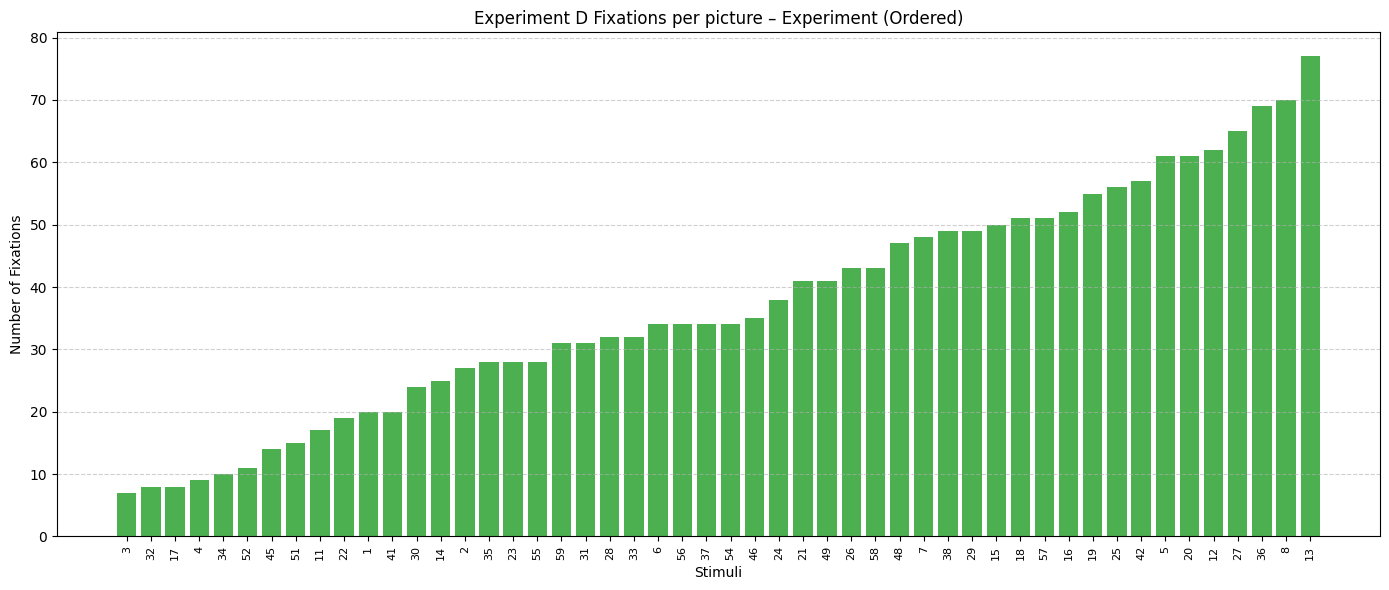

In [17]:


import numpy as np
import matplotlib.pyplot as plt

df_a = trials_data_dict['D'].copy()
df_a_sorted = df_a.sort_values('num_fix')

df_a_sorted = df_a_sorted[df_a_sorted['target_presence'] == True]


colors = '#4CAF50'

plt.figure(figsize=(14, 6))
plt.bar(df_a_sorted['trial_id'].astype(str), df_a_sorted['num_fix'], color=colors)

plt.title('Experiment D Fixations per picture – Experiment (Ordered)')
plt.xlabel('Stimuli')
plt.ylabel('Number of Fixations')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Box Plot

# Third assignment


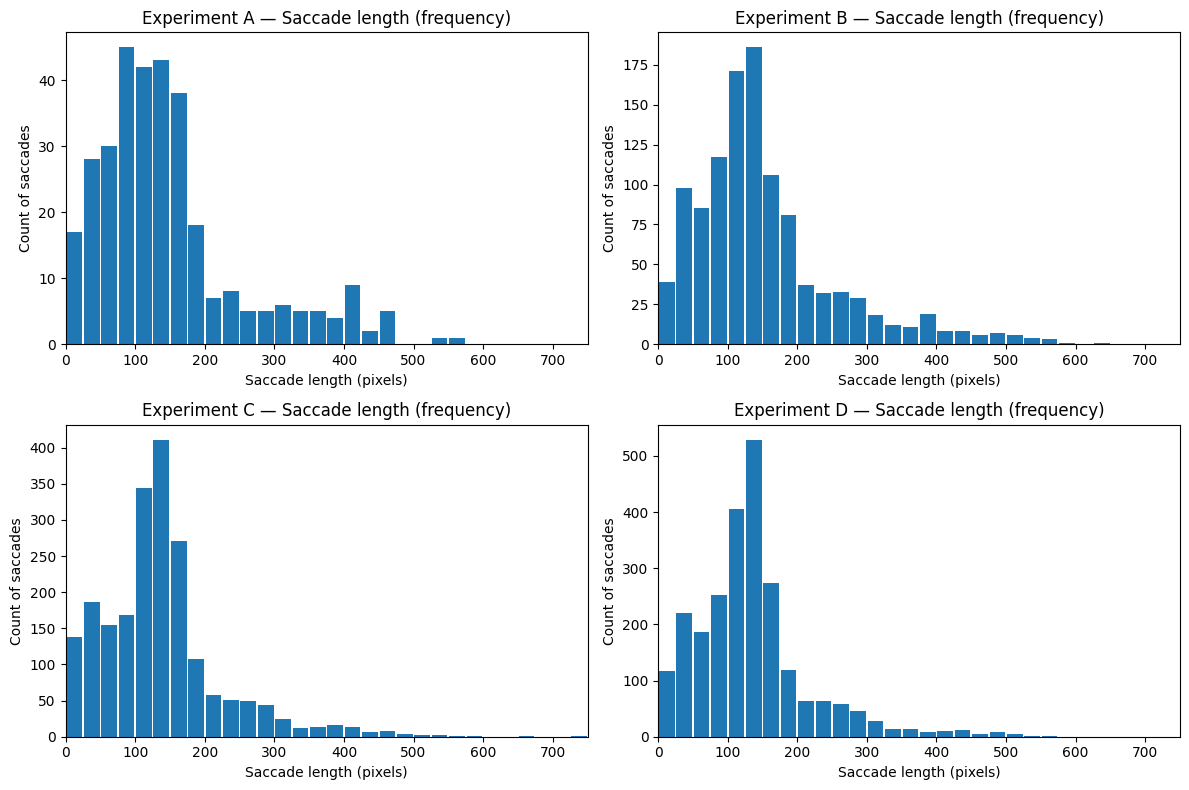

In [18]:

def plot_saccade_length_frequency(saccades_dict, experiments=('A','B','C','D'), bin_width=25):
    all_vals = []
    for k in experiments:
        vals = saccades_dict[k]['distance'].dropna().to_numpy()
        if vals.size: all_vals.append(vals)
    all_vals = np.concatenate(all_vals)
    gmin = np.floor(all_vals.min()/bin_width)*bin_width
    gmax = np.ceil(all_vals.max()/bin_width)*bin_width
    bins = np.arange(gmin, gmax + bin_width, bin_width)
    centers = (bins[:-1] + bins[1:]) / 2
    width = bin_width*0.9

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()

    for ax, k in zip(axes, experiments):
        d = saccades_dict[k]['distance'].dropna().to_numpy()
        counts, _ = np.histogram(d, bins=bins)
        ax.bar(centers, counts, width=width, align='center')
        ax.set_title(f'Experiment {k} — Saccade length (frequency)')
        ax.set_xlabel('Saccade length (pixels)')
        ax.set_ylabel('Count of saccades')
        ax.set_xlim(bins[0], bins[-1])

    for ax in axes[len(experiments):]:
        ax.axis('off')

    plt.tight_layout(); plt.show()

plot_saccade_length_frequency(saccades_dict)



HeatMaps

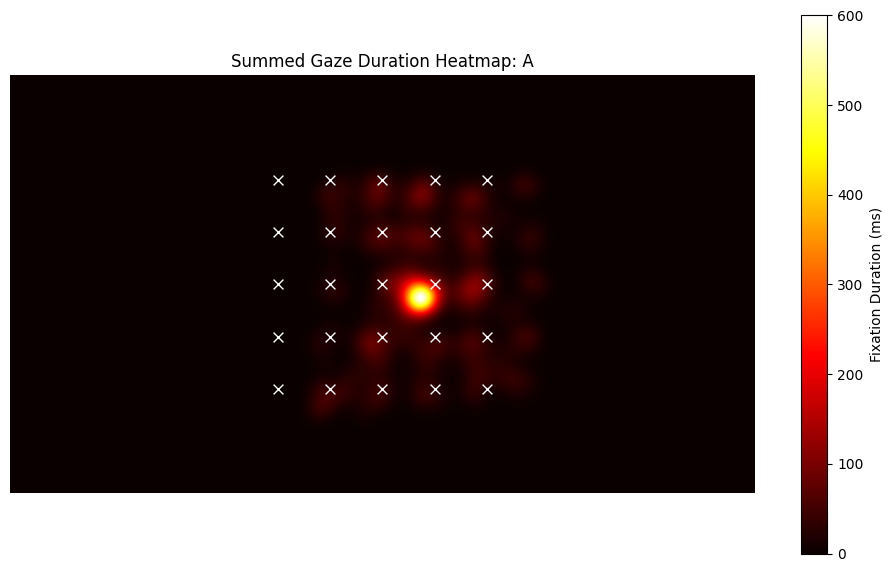

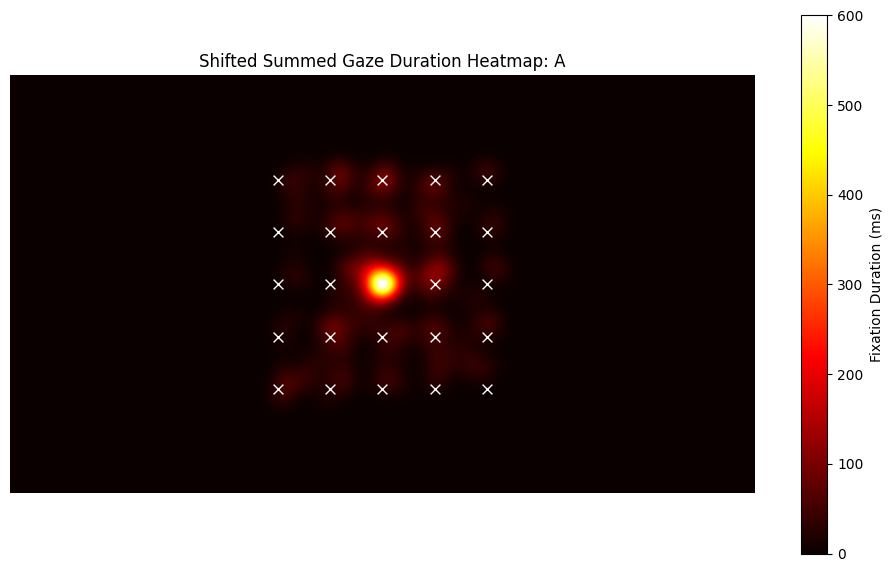

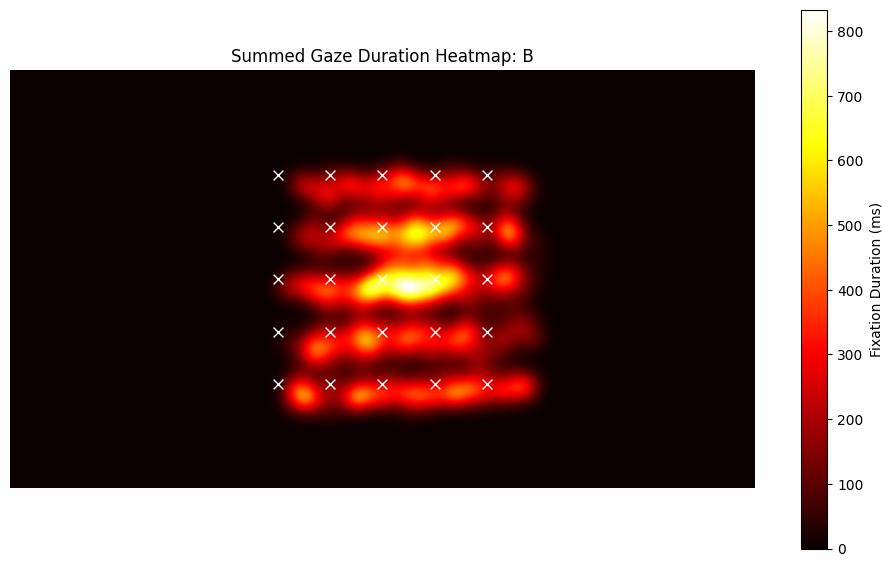

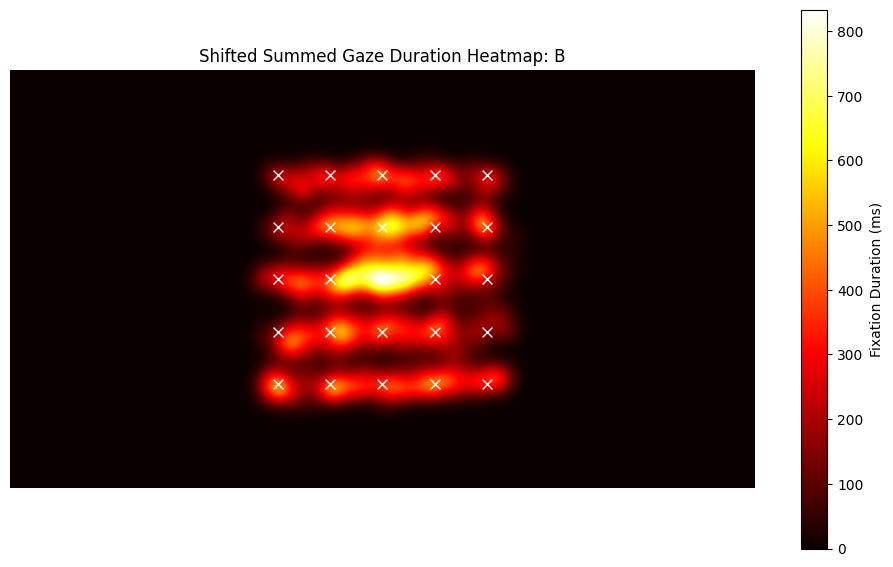

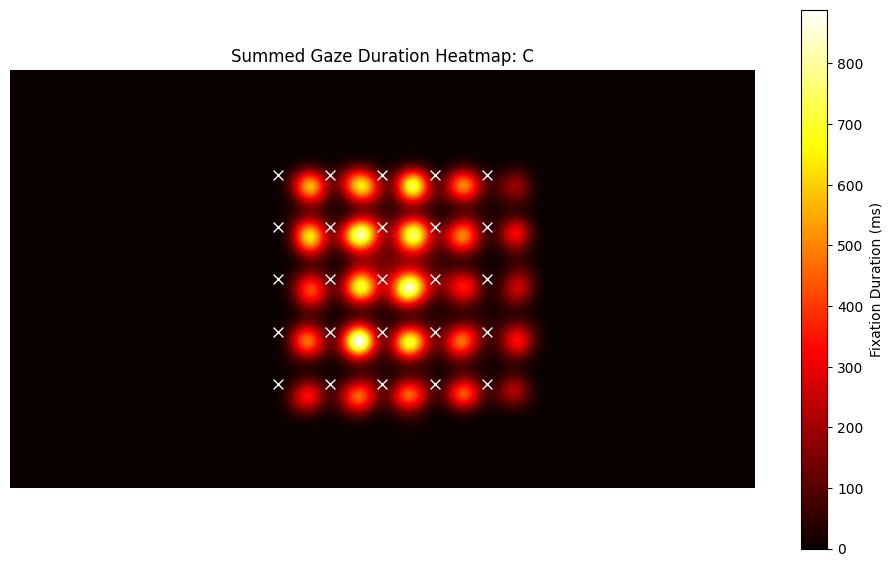

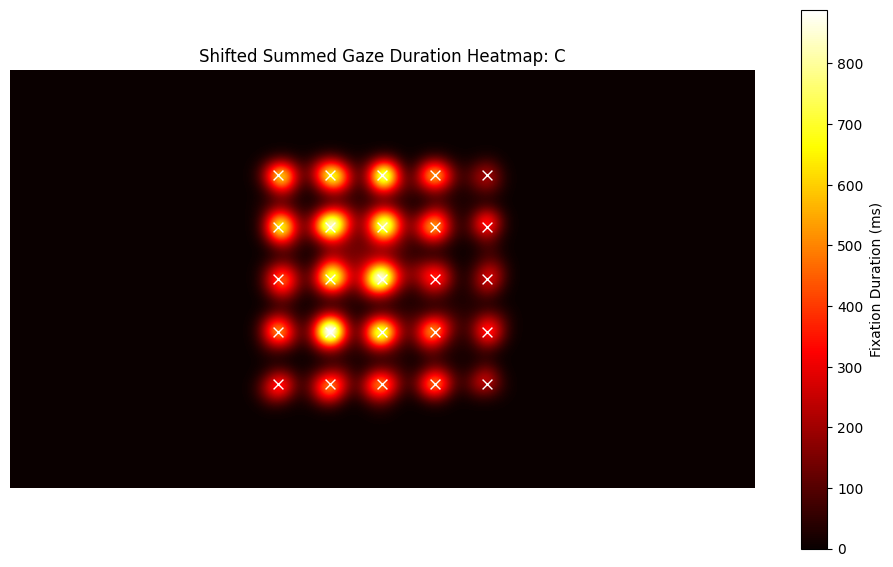

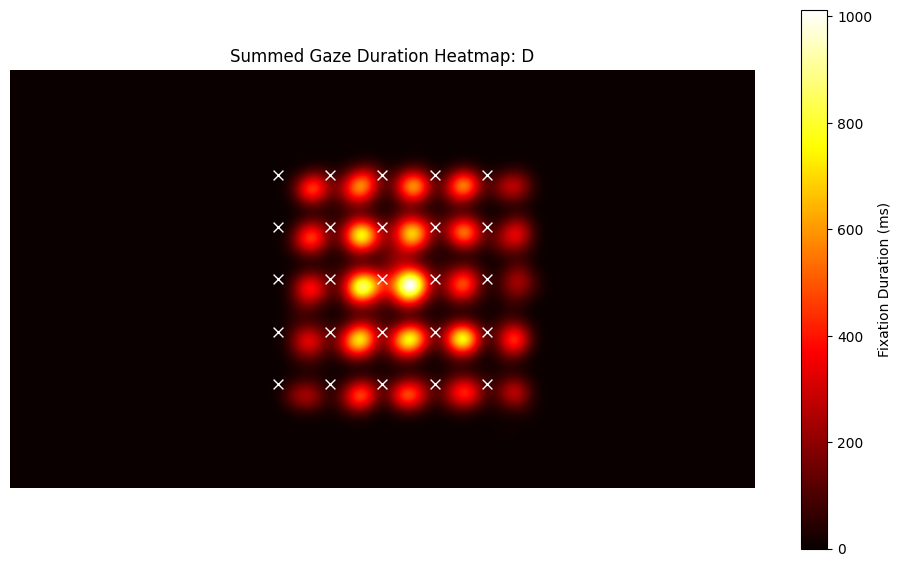

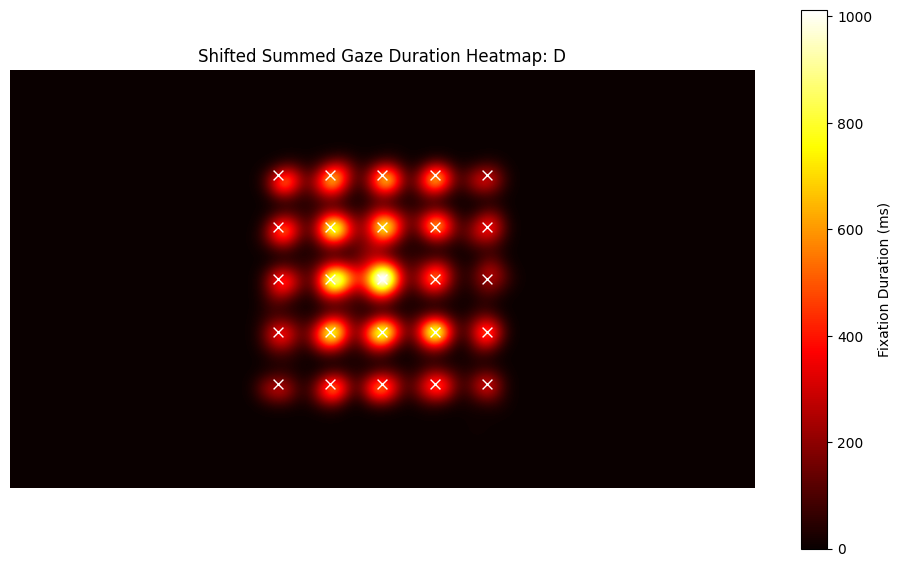

In [20]:
width = 1920
height = 1080

for experiment in experiments:
    # Set up an empty heatmap
    heatmap = np.zeros((height, width)) # height - rows, width - columns
    # Loop over trials 1 to 60
    for trial_num in range(1, 61):
        trial = str(trial_num)  # make sure keys are strings
        if trial in fixations[experiment]:  # check if trial exists
            x = fixations[experiment][trial]['x']
            y = fixations[experiment][trial]['y']
            fix_duration = fixations[experiment][trial]['duration']

            for xi, yi, di in zip(x, y, fix_duration):
                if 0 <= xi < width and 0 <= yi < height:
                    heatmap[int(yi), int(xi)] += di

    # Save original max for rescaling
    original_max = heatmap.max()

    # Apply Gaussian smoothing
    heatmap_smooth = gaussian_filter(heatmap, sigma=25)

    # Rescale to preserve original max
    heatmap_smooth *= original_max / heatmap_smooth.max()

    # Download coordinates 
    with open('grid_coords.txt', 'r') as f:
        grid_coords_txt = [tuple(map(int, line.strip().split(','))) for line in f]

    x_grid_coord, y_grid_coord = zip(*grid_coords_txt)


    max_y, max_x = np.unravel_index(np.argmax(heatmap_smooth), heatmap_smooth.shape)
    if experiment != 'C':
        center_x, center_y = x_grid_coord[12], y_grid_coord[12] #center of the grid 
    else:
        center_x, center_y = x_grid_coord[16], y_grid_coord[16] #center of the grid 
    # Plot
    plt.figure(figsize=(12, 7))
    img = plt.imshow(heatmap_smooth, cmap='hot', interpolation='bilinear')
    plt.scatter(x_grid_coord, y_grid_coord, c='white', marker='x', s=50, linewidths=1)
    plt.colorbar(img, label='Fixation Duration (ms)')
    plt.title("Summed Gaze Duration Heatmap: "+ experiment)
    #plt.colorbar(img, label='Fixation Duration (ms)')
    plt.axis('off')
    # plt.show()


    # SHIFTED SCATTER
    dy = center_y - max_y
    dx = center_x - max_x

    fixations_pd_in_dict[experiment]['shifted_avrxpos'] = fixations_pd_in_dict[experiment]['avrxpos'] + dx
    fixations_pd_in_dict[experiment]['shifted_avrypos'] = fixations_pd_in_dict[experiment]['avrypos'] + dy
    
    # Shift the smoothed heatmap
    from scipy.ndimage import shift
    heatmap_shifted = shift(heatmap_smooth, shift=(dy, dx), mode='constant', cval=0)

    plt.figure(figsize=(12, 7))
    img = plt.imshow(heatmap_shifted, cmap='hot', interpolation='bilinear')
    plt.scatter(x_grid_coord, y_grid_coord, c='white', marker='x', s=50, linewidths=1)
    plt.colorbar(img, label='Fixation Duration (ms)')
    plt.title("Shifted Summed Gaze Duration Heatmap: "+ experiment)
    #plt.colorbar(img, label='Fixation Duration (ms)')
    plt.axis('off')
    # plt.show()


    # DRAWING shifted traces
    for i in range(1, 61):
        trial_id = str(i)
        # trials_data_dict[experiment] = trials_trials_data_dict[experiment]_dict[experiment]
        trial_info = trials_data_dict[experiment].loc[trials_data_dict[experiment]['trial_id'] == int(trial_id)]

        stime = trial_info['start_trial'].iloc[0]
        etime = trial_info['end_trial'].iloc[0]
        asc = asc_samples_dict[experiment]
        timestemps = asc.loc[(asc['time'] >= stime) & (asc['time'] <= etime)].copy().assign(x=lambda df: df['x'] + dx,
                          y=lambda df: df['y'] + dy)

        
        csv_data = csv_dict[experiment]
        target_area = csv_data.loc[csv_data['N_trial'] == int(trial_id)]
        
        fix = fixations_pd_in_dict[experiment].loc[fixations_pd_in_dict[experiment]['trial_id'] == str(trial_id)].copy().assign(
            avrxpos=lambda df: df['avrxpos'] + dx, 
            avrypos=lambda df: df['avrypos'] + dy
)
        


        traces = drawing_traces(stimuli_img_path_dict[experiment], write_traces_folder_dict[experiment], stimuli_path, 
                                trial_id, timestemps, 
                                fix, target_area)
        
        
        #  *UNCOMMENT* Video traces movie
        # img_path = os.path.join(write_traces_folder_dict[experiment], f'traces_trial_{i}.png')
        # movie_traces(img_path, timestemps, i, write_video_folder_dict[experiment])

Histograms

Fixation duration in experiements

(Note):

in A and B, there are LESS fixations, so thus the frequency is not same as in A it is 5 fixations per image = 300 in total, in C it is 20 fixations per image = 1200 in total